# Experiment 04

This Experiment is the main experiment of the work, consists in run an optimized Random Forest in order to try to predict the values in question.(https://www.researchgate.net/publication/221533996_From_an_artificial_neural_network_to_a_stock_market_day-trading_system_A_case_study_on_the_BMF_BOVESPA).

This method consists in using the sliding window 

In [1]:
import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor

### Constants and Parameters

In [2]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5

In [3]:
TEST_BEGIN = '2020.06.01'
TEST_END = '2021.06.01'

WINDOW = 700
DRIFT = 4

TIMES = 1

def safeDate(df, begin, period):
    index = df[df['date'] == begin].index[0]
    
    newIndex = index - (period+2)
    newDate = df[df.index == newIndex].date
    
    return newDate.iloc[0]

### Opening the dataset

In [4]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

beginDate = safeDate(df, TEST_BEGIN, WINDOW)

df2 = pd.read_csv('../Data/VALE3_Daily.csv', sep = "\t")
df2.columns = dfColumns
df2 = removeColumns(df2, ['tickvol', 'volume','spread'])

In [5]:
#PETR4
df = calculateEMA(df,DAYS,newColumns)
df = calculateBB(df,DAYS,newColumns)
df = addPreviousDays(df,DAYS, newColumns)

#VALE3
df2 = calculateEMA(df2,DAYS,newColumns)
df2 = calculateBB(df2,DAYS,newColumns)
df2 = addPreviousDays(df2,DAYS, newColumns)

In [6]:
initialDf_PETR4 = getPeriod(df, beginDate ,TEST_END, True)
initialDf_VALE3 = getPeriod(df2,beginDate,TEST_END, True)

In [7]:
initialDf_PETR4

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2017.07.25,11.80,12.02,11.80,11.99,11.767548,11.898038,11.668546,11.794237,12.109500,...,11.82,11.88,11.79,12.04,11.76,12.00,11.79,11.81,11.64,11.74
1,2017.07.26,12.06,12.10,11.77,11.77,11.865032,11.965359,11.702364,11.786158,12.232253,...,11.49,11.51,12.05,12.11,11.82,11.88,11.79,12.04,11.76,12.00
2,2017.07.27,11.84,11.94,11.79,11.79,11.856688,11.956906,11.731576,11.787439,12.128523,...,11.58,11.68,11.79,11.83,11.49,11.51,12.05,12.11,11.82,11.88
3,2017.07.28,11.77,11.91,11.71,11.91,11.827792,11.941271,11.724384,11.828293,12.127418,...,11.80,11.99,11.64,11.72,11.58,11.68,11.79,11.83,11.49,11.51
4,2017.07.31,11.99,12.07,11.85,12.05,11.881861,11.984180,11.766256,11.902195,12.144745,...,11.77,11.77,11.80,12.02,11.80,11.99,11.64,11.72,11.58,11.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,2021.05.26,25.91,26.18,25.65,26.09,26.114791,26.354219,25.760657,26.042263,26.608719,...,25.94,25.95,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15
947,2021.05.27,26.08,26.25,25.77,25.91,26.103194,26.319479,25.763771,25.998175,26.604087,...,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93
948,2021.05.28,26.20,27.02,26.15,26.99,26.135462,26.552986,25.892514,26.328784,26.617551,...,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95
949,2021.05.31,26.96,27.20,26.78,26.87,26.410308,26.768657,26.188343,26.509189,27.147657,...,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39


In [8]:
initialDf_VALE3

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2017.07.25,25.86,26.82,25.86,26.78,25.642986,26.149633,25.407715,25.909778,26.805159,...,25.07,25.13,26.26,26.40,26.01,26.16,26.16,26.28,25.83,26.16
1,2017.07.26,27.04,27.04,25.94,25.95,26.108657,26.446422,25.585143,25.923185,27.467193,...,24.78,24.94,26.10,26.10,25.07,25.13,26.26,26.40,26.01,26.16
2,2017.07.27,25.95,26.43,25.61,25.99,26.055772,26.440948,25.593429,25.945457,27.417838,...,24.94,25.49,25.11,25.41,24.78,24.94,26.10,26.10,25.07,25.13
3,2017.07.28,25.84,26.56,25.66,26.55,25.983848,26.480632,25.615619,26.146971,27.372997,...,25.86,26.78,25.04,25.51,24.94,25.49,25.11,25.41,24.78,24.94
4,2017.07.31,27.56,27.58,27.16,27.39,26.509232,26.847088,26.130413,26.561314,28.046997,...,25.94,25.95,25.86,26.82,25.86,26.78,25.04,25.51,24.94,25.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,2021.05.26,106.37,110.32,106.03,110.20,109.166674,111.131617,107.622606,109.807900,113.973861,...,108.50,109.40,111.70,112.10,110.20,111.11,112.10,112.78,109.84,112.25
947,2021.05.27,110.80,112.09,109.77,110.99,109.711116,111.451078,108.338404,110.201933,113.405981,...,107.51,109.78,111.11,111.25,108.50,109.40,111.70,112.10,110.20,111.11
948,2021.05.28,111.11,112.75,109.42,111.59,110.177411,111.884052,108.698936,110.664622,113.405981,...,106.78,107.05,108.00,110.14,107.51,109.78,111.11,111.25,108.50,109.40
949,2021.05.31,112.50,114.89,112.50,114.78,110.951607,112.886035,109.965957,112.036415,114.811204,...,106.03,110.20,110.28,110.89,106.78,107.05,108.00,110.14,107.51,109.78


#### Experimento 04: Utilizando Random Forest

62
Index(['LB_low', 'd-1_high', 'LB_close', 'LB_open', 'EMA_high', 'd-1_low',
       'EMA_low', 'd-1_close', 'EMA_close', 'open'],
      dtype='object')
[6.72106964e-04 1.19170052e-03 1.22932067e-03 1.31536856e-03
 2.00808948e-03 3.31694633e-03 3.87889056e-03 1.68086175e-02
 2.19749493e-02 9.42724942e-01]


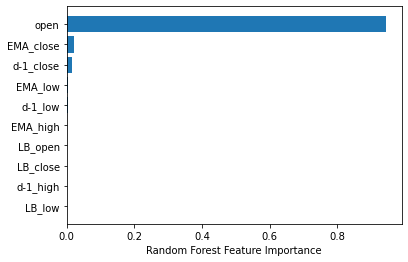

62
Index(['d-1_high', 'd-1_low', 'UB_high', 'UB_low', 'UB_close', 'EMA_low',
       'UB_open', 'd-1_close', 'EMA_close', 'open'],
      dtype='object')
[0.01428319 0.01506653 0.01581714 0.01634452 0.01706569 0.01878962
 0.02043151 0.03269817 0.04175568 0.62391065]


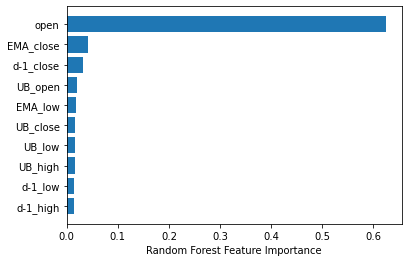

<Figure size 432x288 with 0 Axes>

In [9]:
def getTrainPeriod(df, begin, period):
    
    index = df[df['date'] == begin].index[0]
    index = index-1
    
    endDate = df[df.index == index].date
    beginDate = df[df.index == (index-period)].date
    
    return beginDate.iloc[0], endDate.iloc[0]
    

def exp04(df, stock, inputColumns = []):
    
    beginTrain, endTrain = getTrainPeriod(df,TEST_BEGIN, WINDOW)
    
    df_test_aux = getPeriod(df, TEST_BEGIN, TEST_END)
    
    indexBegin = df_test_aux.head(1).index[0]
    indexEnd = df_test_aux.tail(1).index[0]
    
    acc_importance = []
    iterations = 0;
    
    for i in range (indexBegin, indexEnd, DRIFT):
        #print(i)
        
        df_test = df[(df.index >= i) & (df.index <= i+DRIFT-1)]
        df_train = df[(df.index >= i-WINDOW) & (df.index < i)]
    
        if(inputColumns == []):
            x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
            y_train = df_train[['high','low']]

            x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
            y_test = df_test[['high','low']]
        else:
            x_train = df_train[inputColumns]
            y_train = df_train[['high','low']]

            x_test = df_test[inputColumns]
            y_test = df_test[['high','low']]

        rf = RandomForestRegressor(n_estimators = 500)
        rf.fit(x_train, y_train);
        y_pred = rf.predict(x_test)
        
        #Plotting importances from all executions
        #sorted_idx = rf.feature_importances_.argsort()
        #plt.barh(x_train.columns[sorted_idx[28:]], rf.feature_importances_[sorted_idx[28:]])
        #plt.xlabel("Random Forest Feature Importance")
        #print(x_train.columns[sorted_idx])
        #print(rf.feature_importances_[sorted_idx])
        
        if(i == indexBegin):
            acc_importance = rf.feature_importances_
            iterations = 1
            predDf = y_test.copy()
            predDf['high_pred'] = y_pred[:,0]
            predDf['low_pred'] = y_pred[:,1]
        else:
            acc_importance = np.add(acc_importance,rf.feature_importances_)
            iterations = iterations + 1
            auxDf = y_test.copy()
            auxDf['high_pred'] = y_pred[:,0]
            auxDf['low_pred'] = y_pred[:,1]
            predDf = predDf.append(auxDf)
            
    print(iterations)
    acc_importance = acc_importance/iterations
    sorted_idx = acc_importance.argsort()
    plt.barh(x_train.columns[sorted_idx[23:]], acc_importance[sorted_idx[23:]])
    plt.xlabel("Random Forest Feature Importance")
    
    print(x_train.columns[sorted_idx[23:]])
    print(acc_importance[sorted_idx[23:]])

    plt.show()
    plt.clf()
    
    #print (mape(y_test['high'],y_pred[:,0]))
    #print (mape(y_test['low'],y_pred[:,1]))
    #print (mae(y_test['high'],y_pred[:,0]))
    #print (mae(y_test['low'],y_pred[:,1]))
    
    errorMax = mape(predDf['high'],predDf['high_pred'])
    errorMin = mape(predDf['low'],predDf['low_pred'])
    
    return errorMax, errorMin, predDf
    
errorMax_petr4, errorMin_petr4, predDf_petr4 = exp04(initialDf_PETR4, 'PETR4')
errorMax_vale3, errorMin_vale3, predDf_vale3 = exp04(initialDf_VALE3, 'VALE3')

predDf_petr4['date'] = getPeriod(initialDf_PETR4, TEST_BEGIN, TEST_END)['date']
predDf_vale3['date'] = getPeriod(initialDf_PETR4, TEST_BEGIN, TEST_END)['date']

In [10]:
print('Erro Petr4:')
printResult(errorMax_petr4, 'high')
printResult(errorMin_petr4, 'low')
print('\nErro vale3:')
printResult(errorMax_vale3, 'high')
printResult(errorMin_vale3, 'low')

Erro Petr4:
high: 1.0 +- 0.88 %
low: 0.99 +- 0.9 %

Erro vale3:
high: 1.65 +- 1.87 %
low: 1.68 +- 1.72 %


25
Index(['LB_high', 'd-1_high', 'LB_open', 'LB_close', 'EMA_high', 'd-1_low',
       'EMA_low', 'd-1_close', 'EMA_close', 'open'],
      dtype='object')
[6.52796417e-04 9.56780268e-04 1.19039817e-03 1.25551712e-03
 1.46340555e-03 3.43988800e-03 3.98598712e-03 1.59658484e-02
 2.14304949e-02 9.44789845e-01]


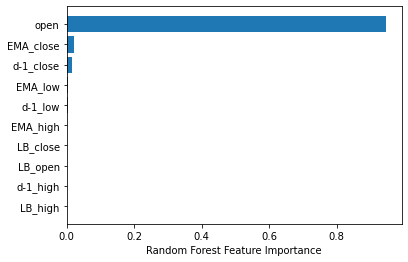

25
Index(['UB_high', 'd-1_high', 'd-1_low', 'UB_close', 'EMA_low', 'UB_low',
       'UB_open', 'd-1_close', 'EMA_close', 'open'],
      dtype='object')
[0.01433718 0.01485094 0.01566373 0.01656537 0.01752529 0.01799231
 0.01831583 0.03199789 0.04022883 0.63102959]


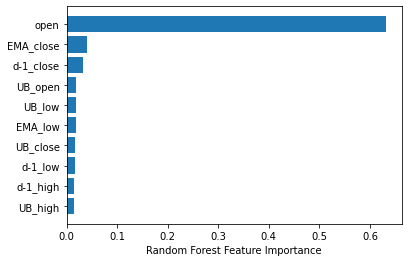

<Figure size 432x288 with 0 Axes>

In [13]:
DRIFT = 10
errorMax_petr4, errorMin_petr4, predDf_petr4 = exp04(initialDf_PETR4, 'PETR4')
errorMax_vale3, errorMin_vale3, predDf_vale3 = exp04(initialDf_VALE3, 'VALE3')